# 50 State of Dismay: The Effect of Abortions Rates on Foster Care Entries
## Correlation One DS4A/Women Capstone Project
### Led by Sasha Gryshchenko
### In collaboration with Priya Balaji, Cassie Berns, Chevaunne Edwards, Paula Wu, Ange Yang

This project focuses on the relationship between abortion rates and infant foster care entry rates, as well as how these vary state by state depending on the political ideology and abortion restrictiveness. This project attempts to address the following two questions:
1. How do restrictive abortion laws impact rates of abortion, foster care entry, and adoption?
2. What factors influence the rate of entry into foster care? 

Note that the data used in this project come from different sources and were cleaned and transformed prior to being loaded into Python.

In [ ]:
pip install plotly

In [ ]:
pip install shap

In [ ]:
pip install category_encoders

In [ ]:
pip install xgboost

In [233]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as stats
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [308]:
df = pd.read_csv("Capstone Project Data/merged_data.csv")
df.head()

,Unnamed: 0,state,year,adopted_under1,code,birthstotal,adoptions_per_1000,population_women,abortions,abortion_rate_1000,...,mothers_labor_force_rate,fathers_labor_force_rate,earning_ratio_women_to_men_uni_grads,births,ave_mother_age,ave_num_of_prenatal_visits,status,fostercare_rate_<1_per_1000,abortion_ban,political_ideology
0,0,California,2000,225.0,CA,531959,0.42,7578978,235706.2,31.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,5,Democrat
1,1,California,2005,161.0,CA,548882,0.34,7787065,206357.2,26.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7,5,Democrat
2,2,California,2006,152.0,CA,562440,0.38,7799350,213702.2,27.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,5,Democrat
3,3,California,2007,177.0,CA,566414,0.23,7803744,220846.0,28.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6,5,Democrat
4,4,California,2008,172.0,CA,551779,0.29,7828450,212151.0,27.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,5,Democrat


In [309]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df['year'] = df['year'].astype('float').astype('int').astype('str')

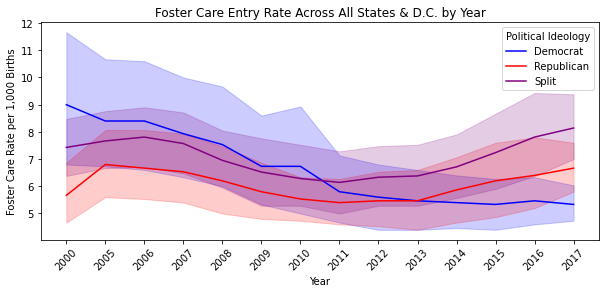

In [310]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df.sort_values(by=['year']),y='foster_care_rate_per_1000',x='year',hue='political_ideology',palette=['blue','red','purple'])
plt.xticks(rotation=45)
plt.title('Foster Care Entry Rate Across All States & D.C. by Year',)
plt.ylabel('Foster Care Rate per 1,000 Births')
plt.xlabel('Year')
plt.legend(title='Political Ideology')

Foster care entries were decreasing up until around 2011, after which the rates started climbing for Republican and Split states, but not Democrat states.

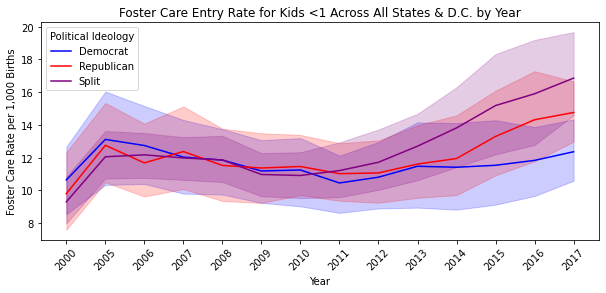

In [311]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df.sort_values(by=['year']),y='fostercare_rate_<1_per_1000',x='year',hue='political_ideology',palette=['blue','red','purple'])
plt.xticks(rotation=45)
plt.title('Foster Care Entry Rate for Kids <1 Across All States & D.C. by Year')
plt.ylabel('Foster Care Rate per 1,000 Births')
plt.xlabel('Year')
plt.legend(title='Political Ideology')

Similar is seen for foster care entries specifically for infants. The table below further proves this point.

In [312]:
round(df[['foster_care_rate_per_1000','political_ideology','year']].
      groupby(['year','political_ideology']).mean().tail(15),1)

foster_care_rate_per_1000
year political_ideology                           
2013 Democrat                                  5.5
     Republican                                5.5
     Split                                     6.4
2014 Democrat                                  5.4
     Republican                                5.9
     Split                                     6.7
2015 Democrat                                  5.3
     Republican                                6.2
     Split                                     7.2
2016 Democrat                                  5.5
     Republican                                6.4
     Split                                     7.8
2017 Democrat                                  5.3
     Republican                                6.7
     Split                                     8.1

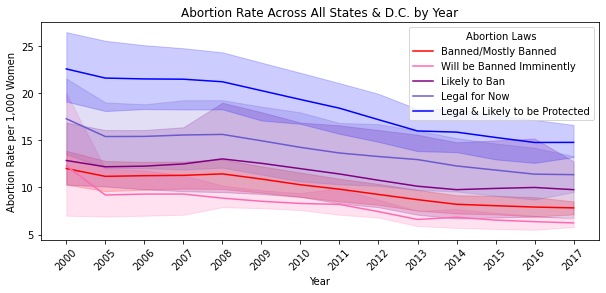

In [32]:
plt.figure(figsize=(10, 4))
palette = ['red','hotpink','purple','slateblue','blue']
sns.lineplot(data=df.sort_values(by=['year']),x='year',y='abortion_rate_1000',hue='abortion_ban',palette=palette)
plt.xticks(rotation=45)
plt.title('Abortion Rate Across All States & D.C. by Year')
plt.xlabel('Year')
plt.ylabel('Abortion Rate per 1,000 Women')
plt.legend(title='Abortion Laws',
           labels=['Banned/Mostly Banned','Will be Banned Imminently','Likely to Ban','Legal for Now','Legal & Likely to be Protected'])

Abortion rates have been declining in all states over time, but it is clear that the rates are lowest in states with restrictive laws. However, note that the rates reported are only for legal abortions - the rates of illegal abortions are not available, but it is known that "denying women access to legal abortion does not prevent them from having abortions, but just increases the likelihood that they will resort to an illegal abortion carried out under unsafe conditions" according to [Guttmacher](https://www.guttmacher.org/perspectives50/abortion-and-after-legalization#).

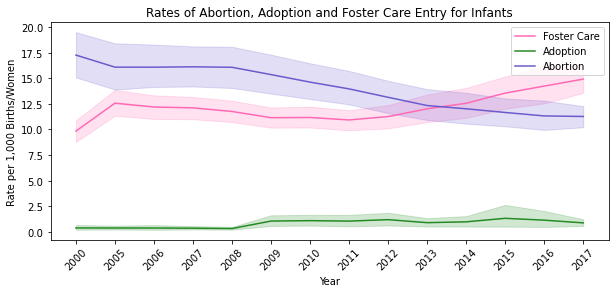

In [35]:
plt.figure(figsize=(10, 4))
ax = sns.lineplot(x="year",y="fostercare_rate_<1_per_1000", data=df.sort_values(by=['year']),color="hotpink") 
ax = sns.lineplot(x="year",y="adoptions_per_1000", data=df.sort_values(by=['year']),color="forestgreen")
ax = sns.lineplot(x="year",y="abortion_rate_1000", data=df.sort_values(by=['year']),color="slateblue")
plt.xticks(rotation=45)
plt.title('Rates of Abortion, Adoption and Foster Care Entry for Infants')
plt.xlabel('Year')
plt.ylabel('Rate per 1,000 Births/Women')
plt.legend(title='',
           labels=["Foster Care","Adoption","Abortion"])

It is seen that the rates of adoption are nowhere near the rates of foster care entry of infants across all years. It is, however, worth noting that, as we saw earlier, the rates of abortion are decreasing and the rates of foster care entries are decreasing, while the rates of adoption remained unaffected. 

Now let's shift focus to analyze how the states are different not only in the rates of aboriton, foster care entries, and adoptions, but socio-economically. Note that demographic information (e.g., age, race, ethnicity, etc.) is not considered in this project in a lot of detail, given the limited time allocated for copletion and limit individual-level data available.

In [313]:
fig = px.choropleth(df,
                    locations='code', 
                    locationmode='USA-states', 
                    scope='usa',
                    color='%women_to_men_full_time_earnings',
                    color_continuous_scale='Viridis_r',
                    hover_name='state',
                    labels={'Earnings Ratio':'% Earnings Ratio'})
fig.update_layout(
      title_text = 'Earnings Ratio - Women to Men (16+)',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45)

In [314]:
fig = px.choropleth(df,
                    locations='code', 
                    locationmode='USA-states', 
                    scope='usa',
                    color='earning_ratio_women_to_men_uni_grads',
                    color_continuous_scale='Viridis_r',
                    hover_name='state',
                    labels={'Earnings Ratio':'% Earnings Ratio'})
fig.update_layout(
      title_text = 'Earnings Ratio - Women to Men (University Graduates, 25+)',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

In [60]:
print("The average income ratio of women to men across the US is",
      round(df['%women_to_men_full_time_earnings'].mean(),1),"%",
      "and the average income ratio of women to men with a university degree across the US is",
      round(df['earning_ratio_women_to_men_uni_grads'].mean(),1),"% .")

The average income ratio of women to men across the US is 78.1 % and the average income ratio of women to men with a university degree across the US is 73.8 % .


We see that there is huge discrepancy in the ratio between women's and men's incomes. It is also the case for women with university-level education. We also know that "More education leads to higher earnings but the gender pay gap is wider among men and women with a bachelor’s degree than among those without." according to [US Census Bureau](https://www.census.gov/library/stories/2019/05/college-degree-widens-gender-earnings-gap.html).

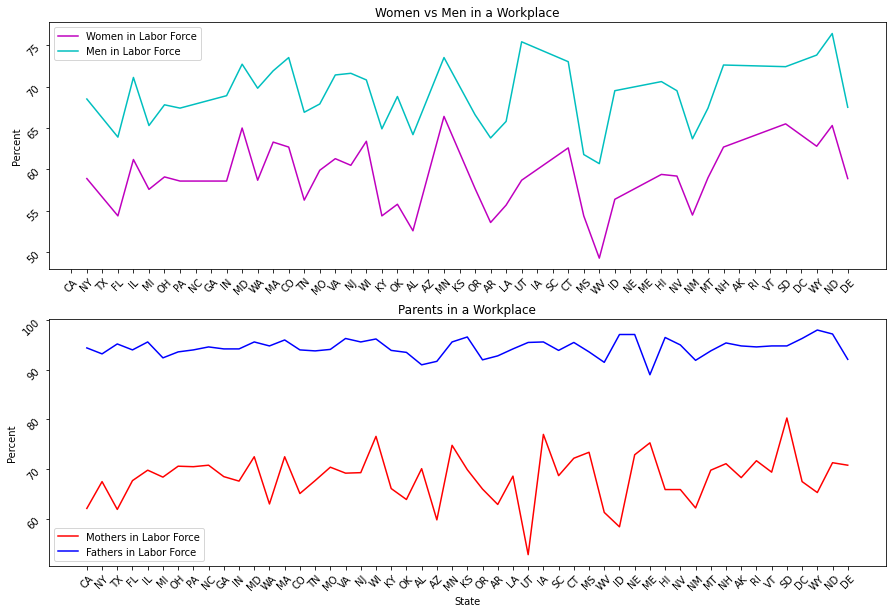

In [134]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.lineplot(data=df,x='code',y='%women_labor_force',color='m',label='Women in Labor Force', ax=ax[0])
sns.lineplot(data=df,x='code',y='%men_labor_force',color='c',label='Men in Labor Force', ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('')
ax[0].set_ylabel('Percent')
ax[0].set_title('Women vs Men in a Workplace')
sns.lineplot(data=df,x='code',y='mothers_labor_force_rate',color='r',label='Mothers in Labor Force', ax=ax[1])
sns.lineplot(data=df,x='code',y='fathers_labor_force_rate',color='b',label='Fathers in Labor Force', ax=ax[1])
ax[1].tick_params(labelrotation=45)
plt.title('Parents in a Workplace')
plt.xlabel('State')
plt.ylabel('Percent')
plt.legend()

We see that the labor force participation rates are very different for women vs men. The difference becomes even more noticable when considering the rates for parents: it is clear that fewer women enter the labor force when compared to men, since mothers are more likely to take on the primary caregiver role than the fathers. [Pew Research](https://www.pewresearch.org/social-trends/2015/11/04/raising-kids-and-running-a-household-how-working-parents-share-the-load/) found that "...in two-parent families, parenting and household responsibilities are shared more equally when both the mother and the father work full time than when the father is employed full time and the mother is employed part time or not employed. But even in households where both parents work full time, many say a large share of the day-to-day parenting responsibilities falls to mothers.", which further proves that there is still a fundamental difference between the two genders (not considering the cases of same sex marriages, gender neutral partners, etc.) when it comes to childcare, wlthough this is slowly shifting.

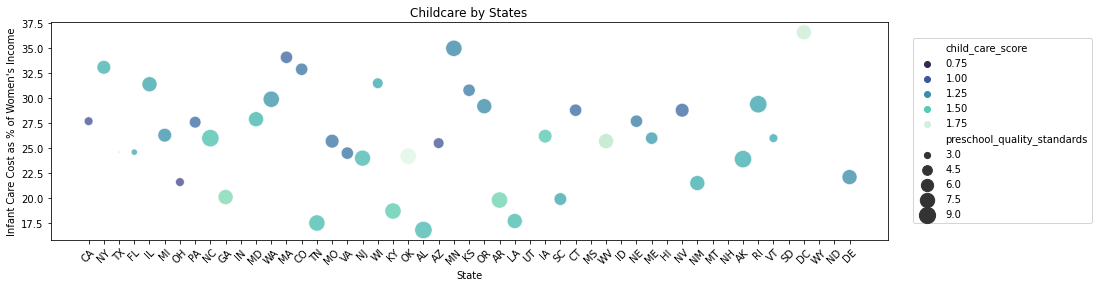

In [105]:
plt.figure(figsize=(15, 4))
sns.scatterplot(x="code", y="%infant_care_to_womens_income",
            data=df,palette='mako',size="preschool_quality_standards",
            hue="child_care_score",sizes=(1,300),alpha=0.75)
plt.xticks(rotation=45)
plt.title('Childcare by States')
plt.xlabel('State')
plt.ylabel("Infant Care Cost as % of Women's Income")
plt.legend(bbox_to_anchor=(1.25, 0.95))

From the plot above it is worth noting that states where the cost of childcare (in proportion to women's income) is low, the child care & preschool quality scores are high.

Now that we have a slightly better understanding of the socioeconomic background of different women by states, we can look more into the different political ideologies in each of the states & see how these relate to abortion restrictiveness.

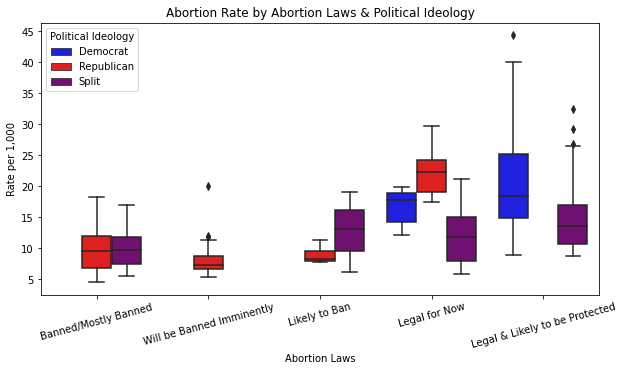

In [113]:
plt.figure(figsize=(10, 5))
g=sns.boxplot(x="abortion_ban", y="abortion_rate_1000", hue='political_ideology', data=df, 
              palette=['blue','red','purple'])
plt.xticks(rotation=15)
plt.title('Abortion Rate by Abortion Laws & Political Ideology')
plt.xlabel('Abortion Laws')
plt.ylabel('Rate per 1,000')
g.set_xticklabels(['Banned/Mostly Banned','Will be Banned Imminently','Likely to Ban','Legal for Now','Legal & Likely to be Protected'])
plt.legend(title='Political Ideology')

In [117]:
df['abortion_ban'].groupby(df['abortion_ban']).count()

abortion_ban
1    240
2     45
3     45
4    120
5    315
Name: abortion_ban, dtype: int64

From the plot & small table above it becomes clear that there are way fewer records for states that will either imminently ban aboritons or are likely to ban them. Using this finding it makes sense to merge these small groups with others. Table below can help in deciding which groups to merge.

In [125]:
df[['abortion_ban','abortion_rate_1000','political_ideology']].groupby(['abortion_ban','political_ideology']).mean()

abortion_rate_1000
abortion_ban political_ideology                    
1            Republican                    9.656667
             Split                         9.860000
2            Republican                    8.015556
3            Republican                    8.800000
             Split                        12.496667
4            Democrat                     16.840000
             Republican                   21.946667
             Split                        11.914444
5            Democrat                     20.200952
             Split                        14.661905

Seems that groups 1 (banned/mostly banned), 2 (will be banned imminently) & 3 (likely to ban) have somewhat similar abortion rates, so these can be merged to form the new group 1 - restrictive abortion laws. Group 4 (legal for now) will form the new group 2 - split views on abortion bans, and group 5 will become 3 - non-restrictive abortion laws.

In [315]:
abortion_ban_dict = {1:1,2:1,3:1,4:2,5:3}
df['abortion_ban'] = df['abortion_ban'].map(abortion_ban_dict)

Given the analytical nature of the work that will be donw with this dataset, it makes sense to convert categorical (string) features to be numeric, such as political idology (order this similarly to the abortion restrictiveness variable) and status, which is a binary varibale on women's health status during her pregnancy.

In [316]:
dfstatus = {'healthy':0,'unhealthy':1}
pol_id = {'Republican':1,'Split':2,'Democrat':3}
df['political_ideology']=df['political_ideology'].map(pol_id)
df['status'] = df['status'].map(dfstatus)

Text(0, 0.5, 'Abortion Restrictiveness')

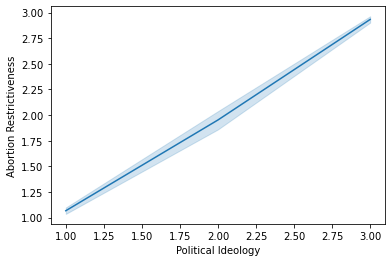

In [317]:
sns.lineplot(x='political_ideology',y='abortion_ban',data=df)
plt.xlabel('Political Ideology')
plt.ylabel('Abortion Restrictiveness')

In [147]:
round(df[['abortion_ban','political_ideology']].corr().iloc[0,1],4)

0.7798

Note that there is a strong positive relationship between political ideology and aboriton restrictiveness (rather negative in a way that it's interpreted) - Republican states have more restrictive aboriton laws, whereas Democratic states have no aboriton restrictions.

It would be interesting how the rates for fostercare entries differ by different political ideologies & abortion restrictions and whether these differences are significant.

[Text(0, 0, 'Republican'), Text(1, 0, 'Split'), Text(2, 0, 'Democrat')]

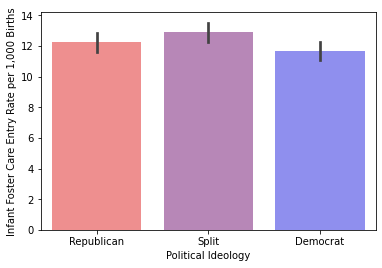

In [318]:
h=sns.barplot(data=df,x='political_ideology',y='fostercare_rate_<1_per_1000',
            palette=['red','purple','blue'],alpha=0.5)
plt.xlabel('Political Ideology')
plt.ylabel('Infant Foster Care Entry Rate per 1,000 Births')
h.set_xticklabels(["Republican","Split","Democrat"])

It seems that foster care entry rate for infants is highest in split states and lowest in Democrat states. Let's see if this difference is significant.

In [319]:
stats.f_oneway(df['fostercare_rate_<1_per_1000'][df['political_ideology'] == 1].dropna(),
               df['fostercare_rate_<1_per_1000'][df['political_ideology'] == 2].dropna(),
               df['fostercare_rate_<1_per_1000'][df['political_ideology'] == 3].dropna())

F_onewayResult(statistic=3.75324498151424, pvalue=0.02387778609520143)

The results of a one-way ANOVA test indicated that there is evidence (p-value of 0.024) to support the hypothesis that the foster care entry rates are indeed different by political ideology group. However, it might be interesting to consider whether the rates are statistically different for Republican vs Democrat states.

In [320]:
stats.f_oneway(df['fostercare_rate_<1_per_1000'][df['political_ideology'] == 1].dropna(),
               df['fostercare_rate_<1_per_1000'][df['political_ideology'] == 3].dropna())

F_onewayResult(statistic=1.5884978409701325, pvalue=0.2082013662655984)

There is not enough evidence to reject the null hypothesis (p-value of 0.208), so we can't conclude whether the two groups are statistically different. What about abortion restriction groups?

[Text(0, 0, 'Restrictive'), Text(1, 0, 'Split'), Text(2, 0, 'Non-Restrictive')]

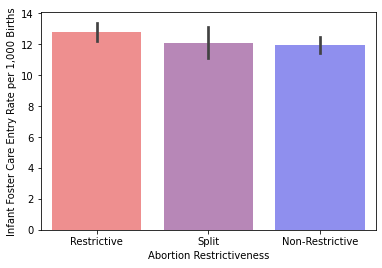

In [321]:
h=sns.barplot(data=df,x='abortion_ban',y='fostercare_rate_<1_per_1000',
            palette=['red','purple','blue'],alpha=0.5)
plt.xlabel('Abortion Restrictiveness')
plt.ylabel('Infant Foster Care Entry Rate per 1,000 Births')
h.set_xticklabels(["Restrictive","Split","Non-Restrictive"])

In [322]:
stats.f_oneway(df['fostercare_rate_<1_per_1000'][df['abortion_ban'] == 1].dropna(),
               df['fostercare_rate_<1_per_1000'][df['abortion_ban'] == 2].dropna(),
               df['fostercare_rate_<1_per_1000'][df['abortion_ban'] == 3].dropna())

F_onewayResult(statistic=2.1669015844724777, pvalue=0.11523996724205135)

From the barplot we see that restrictive states have the highest rates of foster care entries, whereas non-restrictive states have the lowest rates. From the one-way ANOVA test, we see that there is not enough evidence (with p-value of 0.115) to say that the differences between all three groups are significant. What about just restrictive vs non-restrictive groups?

In [323]:
stats.f_oneway(df['fostercare_rate_<1_per_1000'][df['abortion_ban'] == 1].dropna(),
               df['fostercare_rate_<1_per_1000'][df['abortion_ban'] == 3].dropna())

F_onewayResult(statistic=4.185855098098876, pvalue=0.041170835623941436)

Now we see that there is evidence suggesting that there is a difference in foster care entry rates between restrictive vs non-restrictive states (p-value of 0.041).

Using both results, it becomes clearer that there are many factors at play besides each state's political ideology & laws on abortion. There is, however, some evidence to suggest that restrictive & Republican states have higher rates of foster care entry than non-restrictive & Democrat states. But, split states seem to also have high rates, which could be due to how few of these states there are & the history in each of these states (i.e., which party has been prominent in the past).

[Text(0, 0, 'Restrictive'), Text(1, 0, 'Split'), Text(2, 0, 'Non-Restrictive')]

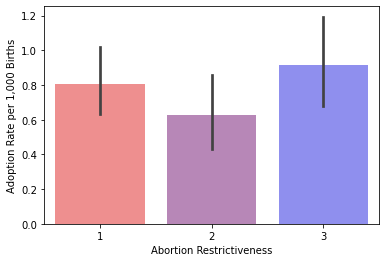

In [324]:
l=sns.barplot(data=df,x='abortion_ban',y='adoptions_per_1000',
            palette=['red','purple','blue'],alpha=0.5)
plt.xlabel('Abortion Restrictiveness')
plt.ylabel('Adoption Rate per 1,000 Births')
h.set_xticklabels(["Restrictive","Split","Non-Restrictive"])

In [327]:
stats.f_oneway(df['adoptions_per_1000'][df['abortion_ban'] == 1].dropna(),
               df['adoptions_per_1000'][df['abortion_ban'] == 2].dropna(),
               df['adoptions_per_1000'][df['abortion_ban'] == 3].dropna())

F_onewayResult(statistic=0.9434112985008115, pvalue=0.389772967035248)

We see that adoptions are highest in non-restrictive states and lowest in split states. It was also found that there is not a statistically significant difference (p-value of 0.340) between the rates of adoption.

Next, we can move onto feature importance analysis, for which Random Forest and XGBoost will be utilized. Although these two methods work better when there are colinear variables (e.g., compared to a tree model or regression), it is still good practice to remove these. However, we need to keep in mind that highly correlated variables maybe be equally important, so the interpretation of the results needs to be adjusted.

Thus, let's beginning by checking which variables are highly correlated (and alike in a sesnse, e.g., political ideology and aboriton restrictiveness) and we can remove these for analyses. First, remove count variables as most variables are recorded as percentages/rates, categorical variables that can't be recoded to be numberic (e.g., states names - one-hot encoding these will create an issue of sparse data), and data on adoptions as this is a consequence of foster care entries and won't help us predict this.

In [279]:
df.drop(['state','births','year','code','birthstotal','population_women','adopted_under1',
         'adoptions_per_1000','abortions','median_women_income','fostercare_under1'],axis=1,inplace=True)

<AxesSubplot:>

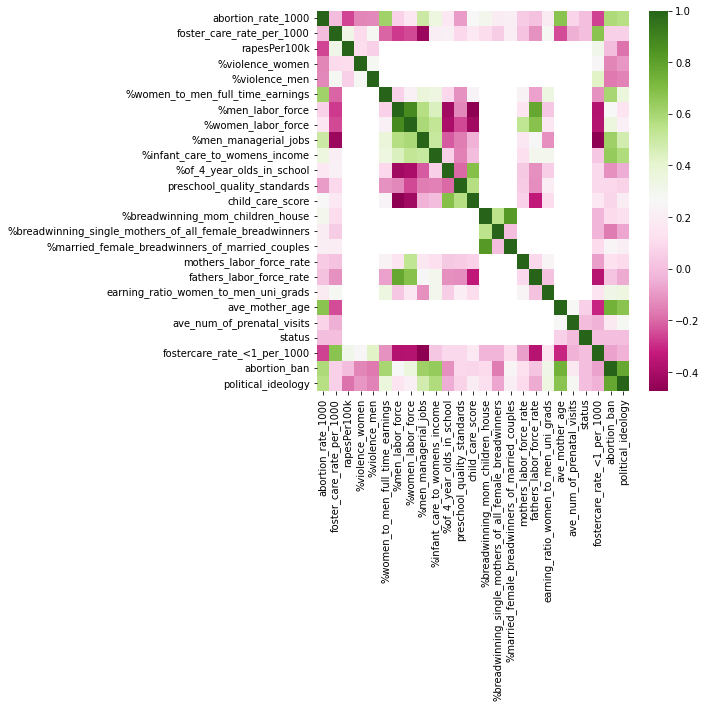

In [201]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(),cmap="PiYG")

In [280]:
df.drop(['foster_care_rate_per_1000','%men_labor_force','%men_managerial_jobs',
         '%breadwinning_single_mothers_of_all_female_breadwinners','fathers_labor_force_rate',
         '%breadwinning_mom_children_house','political_ideology'],axis=1,inplace=True)

Since the data are already sparse (data points for some features are only available for some yers and not others), so it makes sense to impute these with the mean values. We can't drop these observations as then there will be no data left (some data points don't have overlapping years).

In [281]:
df.fillna(df.mean(),inplace=True)

Starting with a train/test split & random forest model.

In [282]:
X = df.drop('fostercare_rate_<1_per_1000',axis=1)
y = df['fostercare_rate_<1_per_1000']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [283]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [284]:
rf_random.best_params_ # best parameters

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [285]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("The MSE of the base Random Forest model is",
      round(mean_squared_error(y_test,y_pred_rf),1)) # base model performance, MSE

The MSE of the base Random Forest model is 29.6


In [287]:
y_pred_rf_random = rf_random.predict(X_test)
print("The MSE of the CV-fitted Random Forest model is",
      round(mean_squared_error(y_test,y_pred_rf_random),1),
     ", so we will use the updated model.") # fitted model after CV, MSE

The MSE of the CV-fitted Random Forest model is 26.0 , so we will use the updated model


Text(0.5, 1.0, 'Random Forest Feature Importance')

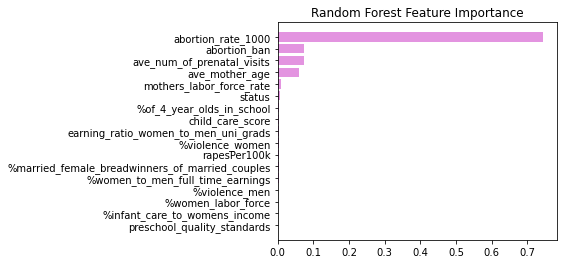

In [288]:
feature_importance_rf = rf_random.best_estimator_.feature_importances_# rf_random.feature_importances_
sorted_idx_rf = np.argsort(feature_importance_rf)
fig = plt.figure(figsize=(5, 4))
plt.barh(range(len(sorted_idx_rf)), feature_importance_rf[sorted_idx_rf], align='center',color='orchid',alpha=0.75)
plt.yticks(range(len(sorted_idx_rf)), np.array(X_test.columns)[sorted_idx_rf])
plt.title('Random Forest Feature Importance')

Moving onto building an XGBoost model.

In [289]:
model_xgb_base = xgb.XGBRegressor()
model_xgb_base.fit(X_train,y_train)
y_pred_xgb_base = model_xgb_base.predict(X_test)
print("The MSE of the base XGBoost model is",
      round(mean_squared_error(y_test,y_pred_xgb_base),1))

The MSE of the base XGBoost model is 24.9


In [290]:
fitted_model_xgb = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15, 20, 25],
    'reg_alpha': [1.1, 1.2],
    'reg_lambda': [1.1, 1.2],
    'subsample': [0.7, 0.8]}
gs_xgb = GridSearchCV(
        estimator=fitted_model_xgb,
        param_grid=param_grid, 
        cv=3, 
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=2)
model_xgb = gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [291]:
model_xgb.best_params_ # best parameters

{'colsample_bytree': 0.7,
 'max_depth': 15,
 'n_estimators': 100,
 'reg_alpha': 1.2,
 'reg_lambda': 1.1,
 'subsample': 0.8}

In [292]:
y_pred_xgb = model_xgb.predict(X_test)
print("The MSE of the CV-fitted XGBoost model is",
      round(abs(model_xgb.best_score_),1),
     ", so we should use the original.")

The MSE of the CV-fitted XGBoost model is 29.1 , so we should use the original


Text(0.5, 1.0, 'XGBoost Feature Importance')

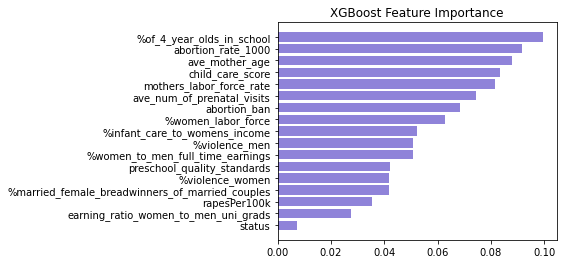

In [293]:
feature_importance_xgb = model_xgb_base.feature_importances_
sorted_idx_xgb = np.argsort(feature_importance_xgb)
fig = plt.figure(figsize=(5, 4))
plt.barh(range(len(sorted_idx_xgb)), feature_importance_xgb[sorted_idx_xgb], align='center',color='slateblue',alpha=0.75)
plt.yticks(range(len(sorted_idx_xgb)),np.array(X_test.columns)[sorted_idx_xgb])
plt.title('XGBoost Feature Importance')

While the assumptions for regression analysis have not been checked (and thus, we can't assume that they are met), we can quickly create a regression model to simply see how the important features relate to foster care entry rates (e.g., state whether the relationship is positive/negative - can use this in combinaiton with correlation results).

Now that we have the results of a Random Forest and an XGBoost models, we can begin to interpret these. Top 5 variables that appear as important features in each model will be shown.

In [294]:
round(df[['fostercare_rate_<1_per_1000','abortion_rate_1000','abortion_ban','mothers_labor_force_rate',
           'ave_num_of_prenatal_visits','ave_mother_age']].corr(),2)

,fostercare_rate_<1_per_1000,abortion_rate_1000,abortion_ban,mothers_labor_force_rate,ave_num_of_prenatal_visits,ave_mother_age
fostercare_rate_<1_per_1000,1.00,-0.26,-0.07,-0.02,-0.02,-0.14
abortion_rate_1000,-0.26,1.00,0.58,0.01,0.02,0.19
abortion_ban,-0.07,0.58,1.00,0.03,0.06,0.27
mothers_labor_force_rate,-0.02,0.01,0.03,1.00,-0.00,-0.00
ave_num_of_prenatal_visits,-0.02,0.02,0.06,-0.00,1.00,0.27
ave_mother_age,-0.14,0.19,0.27,-0.00,0.27,1.00


In [295]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
model_reg = sm.OLS(y_train, X_train).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     fostercare_rate_<1_per_1000   R-squared (uncentered):                   0.870
Model:                                     OLS   Adj. R-squared (uncentered):              0.866
Method:                          Least Squares   F-statistic:                              218.7
Date:                         Wed, 03 Aug 2022   Prob (F-statistic):                   3.46e-233
Time:                                 16:05:43   Log-Likelihood:                         -1710.9
No. Observations:                          573   AIC:                                      3456.
Df Residuals:                              556   BIC:                                      3530.
Df Model:                                   17                                                  
Covariance Type:                     nonrobust                                                  
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
abortion_rate_1000                                 -0.2418      0.037     -6.579      0.000      -0.314      -0.170
rapesPer100k                                     5866.3242   5112.330      1.147      0.252   -4175.517    1.59e+04
%violence_women                                     0.1950      0.184      1.058      0.291      -0.167       0.557
%violence_men                                       0.2111      0.157      1.346      0.179      -0.097       0.519
%women_to_men_full_time_earnings                    0.1174      0.231      0.509      0.611      -0.336       0.570
%women_labor_force                                 -0.1066      0.344     -0.310      0.757      -0.783       0.570
%infant_care_to_womens_income                      -0.0072      0.213     -0.034      0.973      -0.426       0.411
%of_4_year_olds_in_school                          -0.0362      0.064     -0.565      0.573      -0.162       0.090
preschool_quality_standards                        -0.6664      0.630     -1.058      0.290      -1.903       0.570
child_care_score                                    4.8542      4.460      1.088      0.277      -3.907      13.615
%married_female_breadwinners_of_married_couples     0.2092      0.185      1.129      0.259      -0.155       0.573
mothers_labor_force_rate                           -0.0269      0.190     -0.142      0.887      -0.400       0.346
earning_ratio_women_to_men_uni_grads                0.2670      0.186      1.439      0.151      -0.098       0.632
ave_mother_age                                     -0.9222      0.486     -1.896      0.058      -1.878       0.033
ave_num_of_prenatal_visits                         -0.3428      1.003     -0.342      0.733      -2.313       1.627
status                                              0.4235      1.150      0.368      0.713      -1.835       2.682
abortion_ban                                        0.8240      0.280      2.941      0.003       0.274       1.374
==============================================================================
Omnibus:                      137.318   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              352.986
Skew:                           1.201   Prob(JB):                     2.24e-77
Kurtosis:                       6.002   Cond. No.                     4.12e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain 

To have the abortion-related findings refresher in mind, refer to the plots below.

[Text(0, 0, 'Restrictive'), Text(1, 0, 'Split'), Text(2, 0, 'Non-Restrictive')]

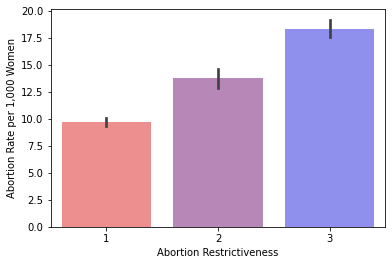

In [328]:
k=sns.barplot(data=df,x='abortion_ban',y='abortion_rate_1000',
            palette=['red','purple','blue'],alpha=0.5)
plt.xlabel('Abortion Restrictiveness')
plt.ylabel('Abortion Rate per 1,000 Women')
h.set_xticklabels(["Restrictive","Split","Non-Restrictive"])

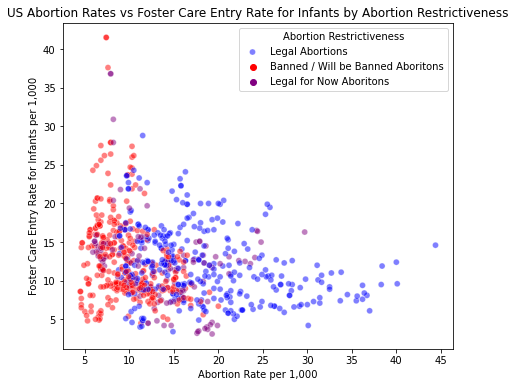

In [329]:
pal = {1: "red", 2: "purple", 3: "blue"}
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df, x="abortion_rate_1000", y="fostercare_rate_<1_per_1000", hue="abortion_ban",
            palette=pal, alpha=0.5)
plt.title("US Abortion Rates vs Foster Care Entry Rate for Infants by Abortion Restrictiveness")
plt.xlabel('Abortion Rate per 1,000')
plt.ylabel('Foster Care Entry Rate for Infants per 1,000')
plt.legend(labels=['Legal Abortions','Banned / Will be Banned Aboritons','Legal for Now Aboritons'],
           title='Abortion Restrictiveness')

We can now return to the original questions and attempt to answer these:

1. *How do restrictive abortion laws impact rates of abortion, foster care entry, and adoption?*

     From correlation analysis and using visualizations, we found that restrictive aboriton laws result in lower rates of **legal** abortions, higher rates of infant foster care entries, and lower rate of infant adoption, whereas the oppositse is seen in less restrictive states. Interestingly enough, results are mixed fro split states and the findings vary on a case-by-case bases, so we cannot speak too much to what conclusions shall be drawn for these.
     
     
     
2. *What factors influence the rate of entry into foster care?*
    
    From the analysis above, the following features were found to be important in relation to infant foster care entry rates: abortion rate, aboriton restrictiveness (and consequently, political ideology), women's health during pregnancy (in the form of prenatal visit frequency and overall health status), pregnant women's age, and mothers' labor force participation rate.